In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Постановка задачи

Необходимо спрогнозировать отказ мотора на основе показаний датчиков.

Данные показаний датчиков описываются следующим образом:
* id -- идентификатор мотора
* cycle -- цикл работы
* p00-p20 -- показания датчиков считываемые в процессе работы
* s0, s1 -- настройки изменяемые в конце каждого цикла

Необходимо предложить решение задачи прогнозирования отказа моторов и варианты использования этого решения на практике.
Считается, что максимальный цикл мотора в данных -- это последний цикл перед поломкой.
Нужно предложить варианты использования полученной модели на практике.

Доп. задание: предложить альтернативную постановку задачи прогноза отказа моторов.

# Предварительный обзор данных

In [4]:
df = pd.read_csv('data.csv', sep=',')
df.head()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      16138 non-null  int64  
 1   cycle   16138 non-null  int64  
 2   p00     16138 non-null  float64
 3   p01     16138 non-null  float64
 4   p02     16138 non-null  float64
 5   p03     16138 non-null  float64
 6   p04     16138 non-null  float64
 7   p05     16138 non-null  float64
 8   p06     16138 non-null  float64
 9   p07     16138 non-null  float64
 10  p08     16138 non-null  int64  
 11  p09     16138 non-null  int64  
 12  p10     16138 non-null  int64  
 13  p11     16138 non-null  float64
 14  p12     16138 non-null  float64
 15  p13     16138 non-null  float64
 16  p14     16138 non-null  float64
 17  p15     16138 non-null  float64
 18  p16     16138 non-null  float64
 19  p17     16138 non-null  float64
 20  p18     16138 non-null  float64
 21  p19     16138 non-null  float64
 22

Всего в данном наборе 16138 строк, все атрибуты которых являются численными и не содержат отсутствующие значения. Данное обстоятельство значительно облегчает дальнеший анализ.

## Число уникальных моторов

In [6]:
motors_num = df.id.nunique()
motors_num

80

## Сколько циклов работы на каждый мотор

In [7]:
df.groupby(['id'])['cycle'].count().sort_values(ascending=False)

id
69    362
67    313
2     287
64    283
17    276
     ... 
24    147
58    147
70    137
57    137
39    128
Name: cycle, Length: 80, dtype: int64

<AxesSubplot:>

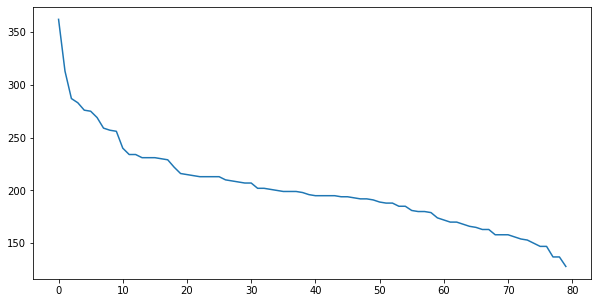

In [8]:
df.groupby(['id'])['cycle'].count().sort_values(ascending=False).plot(x='id', figsize=(10, 5), use_index=False)

# Поиск новых свойств и определение задачи

Разумно будет предположить, что для задачи прогнозирования поломки мотора нужно использовать регрессионные модели. Для этого необходимо выбрать параметр, значение которого они будут предсказывать для каждого

Известно, что последний цикл для каждого мотора явлется последним перед выходом из строя. Также для каждого мотора известно полное число отработанных циклов. Отсюда можно ввести новый параметр для каждого состояния  -- число циклов до отказа (cycles_to_failure).

In [9]:
cycles = df
cycles['cycles_to_failure'] = cycles.groupby('id')['cycle'].transform('last')
cycles['cycles_to_failure'] = cycles['cycles_to_failure'] - cycles['cycle']
cycles['cycles_to_failure'].head()

0    191
1    190
2    189
3    188
4    187
Name: cycles_to_failure, dtype: int64

Также интерес вызывают параметры s1 и s2. Возможно, имеет смысл рассматривать изменение значений этих параметров не относительно каждого нового цикла, а относительного самого первого для данного мотора. Для этого рассчитываем аккумулирующую сумму для этих параметров для каждого мотора.

In [10]:
cycles['cumsum_s1'] = cycles.groupby('id')[['s1']].cumsum()
cycles['cumsum_s2'] = cycles.groupby('id')[['s1']].cumsum()

cycles[['s1', 'cumsum_s1']].head()

,s1,cumsum_s1
0,-0.0007,-0.0007
1,0.0019,0.0012
2,-0.0043,-0.0031
3,0.0007,-0.0024
4,-0.0019,-0.0043


# Статистические характеристики

In [11]:
cycles['cycles_to_failure'].describe()

count    16138.000000
mean       104.548147
std         65.915295
min          0.000000
25%         50.000000
50%        100.000000
75%        152.000000
max        361.000000
Name: cycles_to_failure, dtype: float64

Видно, что значение числа циклов до отказа имеет очень сильный разброс.
Возможно, графическая визуализация распределения параметров поможет лучше понять природу имеющихся данных.

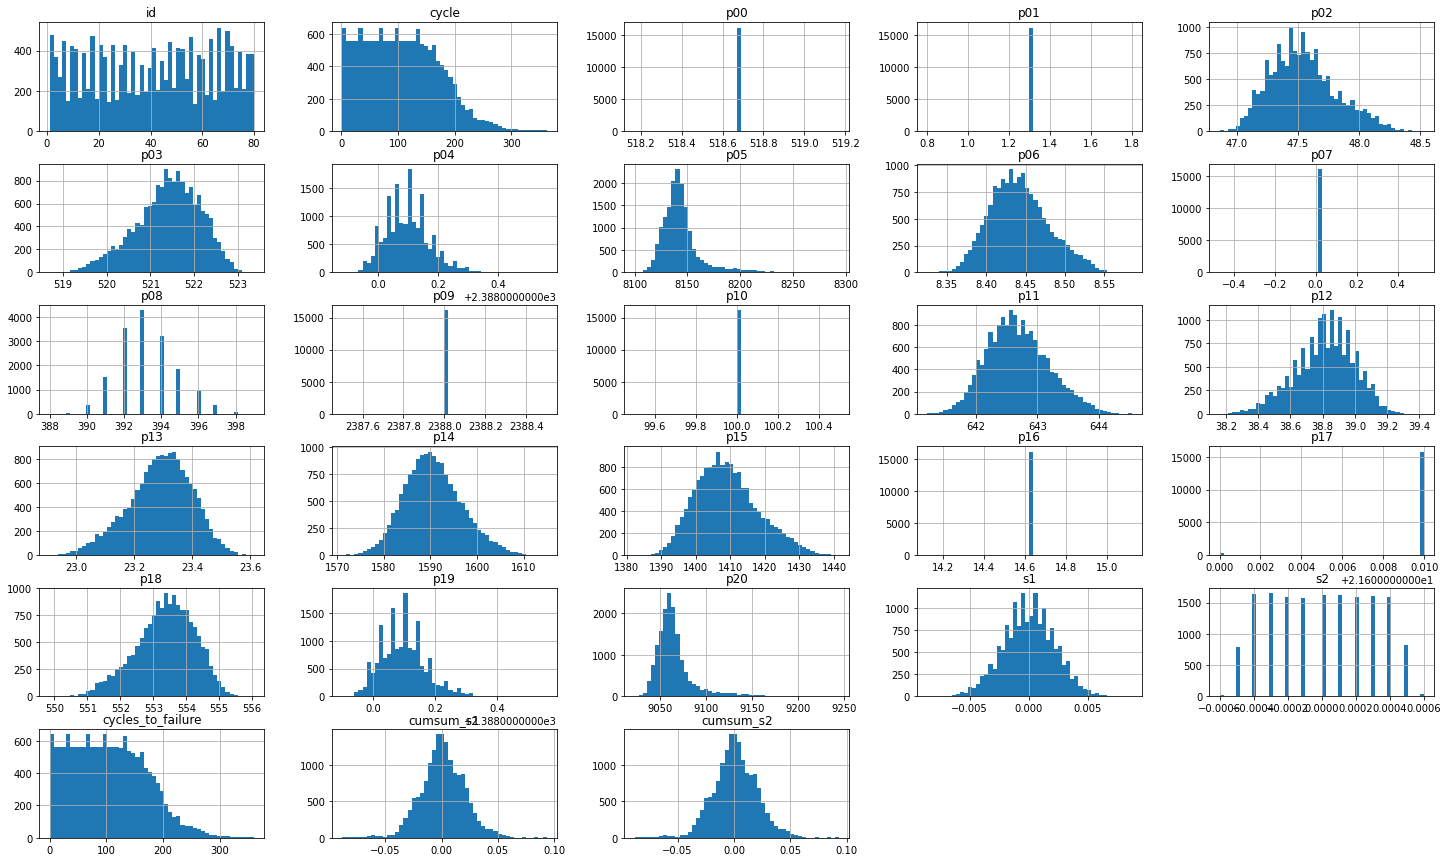

In [12]:
cycles.hist(bins=50, figsize=(25, 15))
plt.show()

Отсюда видно, что большинство показаний с конкретных датчиков распределены нормальным образом. Некоторst из них не изменяется вообще (p00, p01, p07, p09, p10, p16,  p17 ,p14, p15).

Также большинство показаний имеют очень разный масштаб, поэтому в дальнейшем надо будет задействовать стандартизацию.

# Корреляционный анализ

Корреляционный анализ может показать, если ли зависимости между представленными величинами и насколько они сильны.

In [13]:
corr_matrix = cycles.corr()

In [14]:
corr_matrix['cycles_to_failure'].sort_values(ascending=False)

cycles_to_failure    1.000000
p03                  0.678935
p18                  0.662448
p13                  0.646511
p12                  0.637581
id                   0.028491
cumsum_s1            0.003324
cumsum_s2            0.003324
s1                  -0.000150
s2                  -0.002669
p17                 -0.133559
p05                 -0.310472
p20                 -0.391014
p19                 -0.566356
p04                 -0.566580
p14                 -0.590030
p08                 -0.613475
p11                 -0.616728
p06                 -0.648625
p15                 -0.686511
p02                 -0.704527
cycle               -0.769964
p00                       NaN
p01                       NaN
p07                       NaN
p09                       NaN
p10                       NaN
p16                       NaN
Name: cycles_to_failure, dtype: float64

На первый взгляд видно, что большинство представленных величин имеют значительные коеффициенты корреляции, что говорит о возможной зависимости. Исключения составляют те параметры, значение которых не изменяются за весь период измерения (p00, p01, p09, p10, p16), а также s1, s2 и их аккумулированные суммы. Аккуммулированные суммы имеют чуть больший коэффициент корреляции, но не настолько значительный, чтобы их можно было принимать как значащие параметры. Данное наблюдение дает обоснование попробовать исключить данные параметры из исходной выборки для дальнейшего обучения модели.

Первое впечатление может закрепить графическая визуализация.

array([[<AxesSubplot:xlabel='cycles_to_failure', ylabel='cycles_to_failure'>,
        <AxesSubplot:xlabel='p03', ylabel='cycles_to_failure'>,
        <AxesSubplot:xlabel='p18', ylabel='cycles_to_failure'>,
        <AxesSubplot:xlabel='p13', ylabel='cycles_to_failure'>,
        <AxesSubplot:xlabel='p02', ylabel='cycles_to_failure'>,
        <AxesSubplot:xlabel='cycle', ylabel='cycles_to_failure'>],
       [<AxesSubplot:xlabel='cycles_to_failure', ylabel='p03'>,
        <AxesSubplot:xlabel='p03', ylabel='p03'>,
        <AxesSubplot:xlabel='p18', ylabel='p03'>,
        <AxesSubplot:xlabel='p13', ylabel='p03'>,
        <AxesSubplot:xlabel='p02', ylabel='p03'>,
        <AxesSubplot:xlabel='cycle', ylabel='p03'>],
       [<AxesSubplot:xlabel='cycles_to_failure', ylabel='p18'>,
        <AxesSubplot:xlabel='p03', ylabel='p18'>,
        <AxesSubplot:xlabel='p18', ylabel='p18'>,
        <AxesSubplot:xlabel='p13', ylabel='p18'>,
        <AxesSubplot:xlabel='p02', ylabel='p18'>,
        <AxesSubpl

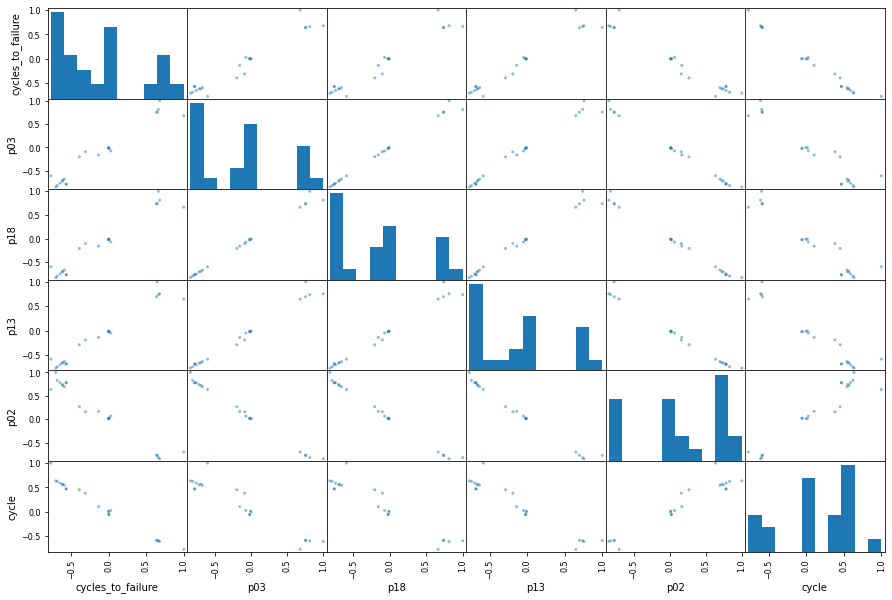

In [15]:
from pandas.plotting import scatter_matrix
attr = ['cycles_to_failure', 'p03', 'p18', 'p13', 'p02', 'cycle']
scatter_matrix(corr_matrix[attr], figsize=(15, 10))

<AxesSubplot:xlabel='p03', ylabel='cycles_to_failure'>

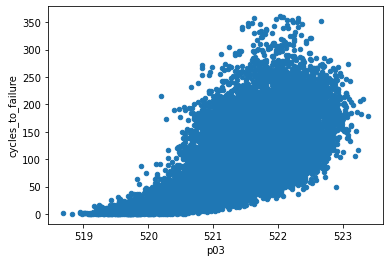

In [16]:
cycles.plot(kind='scatter', x='p03', y='cycles_to_failure')

<AxesSubplot:xlabel='p02', ylabel='cycles_to_failure'>

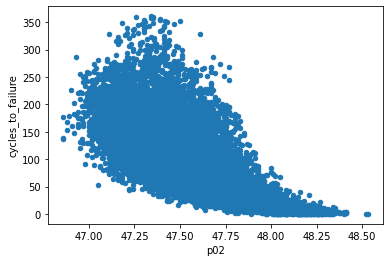

In [17]:
cycles.plot(kind='scatter', x='p02', y='cycles_to_failure')

<AxesSubplot:xlabel='s1', ylabel='cycles_to_failure'>

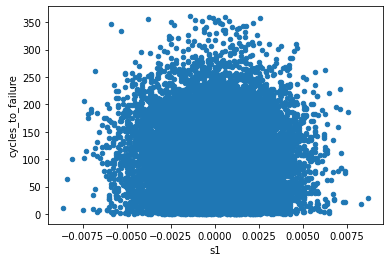

In [18]:
cycles.plot(kind='scatter', x='s1', y='cycles_to_failure')